## **Agent-Based Model of Word-of-Mouth Marketing and Customer Satisfaction**

### **Purpose and Intent**

This project aims to simulate the dynamics of word-of-mouth (WOM) marketing and customer satisfaction in a competitive context. The model focuses on two stores (Blue and Red) contesting customer loyalty in a continuous space. Customers can visit the store, be satisfied, become advocates, and influence the purchase likelihood of other neutral customers.

The ultimate goal is to explore the effectiveness of customer satisfaction and WOM marketing in driving customer acquisition.

### **Model description**

#### **Agents**

**1. ShopAgent**
- **Attributes**:
  - `id`: Unique identifier for the shop.

  - `position`: Fixed `(x, y)` coordinates.
  - `color`: Shop identity (`:blue` or `:red`).
  - `satisfaction_probability`: The chance of satisfying (0.0 to 1.0) visiting customers for each shop.
  - `catalog`: The product provided by each shop

**2. CustomerAgent**
- **Attributes**:
  - `id`: Unique identifier.
  
  - `pos`: Dynamic `(x, y)` coordinates.
  - `vel`: Moving velocity of each customer.
  - `status`: Loyalty state (`:neutral`, `:blue_influenced`, `:red_influenced` , `:blue_advocate`, `:red_advocate`).
  - `satisfaction_level`: Measure of happiness after visiting a shop (`0.0` to `1.0`).
  - `trust_level`: Probability of successfully influencing others (`0.0` to `1.0`).
  - `direction`: Movement vector `(dx, dy)` for navigating the space.
  - `favorite`: The product that customer want to buy.
  - `step_count`: Count the number of step of each customer.

#### **Environment**
A continuous 2D space (`100 x 100`) represents the geographical or social setting:
- **Shops**:
  - Shop are fixed points with defined locations.

  - Each store's product catalog will be randomly assigned from the list of products circulating on the market.
- **Customers**:
  - Customers move dynamically, either randomly or directed toward shops due to WOM influence.

  - Each customer will have a random list of preferred products based on the market's current list.

#### **Rules**

**1. Movement**
- Neutral customers move randomly unless influenced by an advocate.

- Influenced customers adjust their direction to move toward the advocate’s shop.
- Advocates perform a random walk unless specific logic changes their direction.

**2. Shop Visit**
- Customers within a shop's radius (`2.0 units`) may visit.

- If a customer visits a store where the `catalog` has a product they like (`favorite`), the store has a chance (based on `satisfaction_probability`) to turns the customer into an advocate with `satisfaction_level` = 1.0
- If an advocate (e.g., `:blue_advocate`) visits the competitor’s shop (e.g., Red shop), the effective of `satisfaction_probability` of the competitor's shop is reduced significantly. (e.g., 0.2 * `satisfaction_probability`)

**3. Word-of-Mouth Influence**
- Advocates influence nearby neutral customers (radius: `1.0`).

- Influence success is based on:

  ``influence_power`` = ``trust_level`` *0.5 + ``satisfaction_level``*0.5

  if ``influence_power`` greater than a specific threshold.
- Influenced customers adjust their direction toward the advocate’s shop.
- Advocates lose satisfaction over time (e.g., 0.25% per time step).
- Advocates with `satisfaction_level` = 0.0 revert to neutral.

### **Install and import packaged**

In [25]:
import Pkg;
Pkg.add(["Agents", "Random", "Plots", "CairoMakie", "DataFrames"])

    Updating registry at `C:\Users\chumi\.julia\registries\General.toml`
   Resolving package versions...
    Updating `C:\Users\chumi\.julia\environments\v1.11\Project.toml`
  [a93c6f00] + DataFrames v1.7.0
  No Changes to `C:\Users\chumi\.julia\environments\v1.11\Manifest.toml`


In [26]:
# Load required packages
using Agents
using Random
using Plots
using CairoMakie
using LinearAlgebra
using DataFrames

### **Defining Agents**

#### **Shop Agent**

The `ShopAgent` represents a store in the simulation positioned at a fixed location within a continuous 2D space. Each store differs in its ability to satisfy customers (`satisfaction_probability`) and offers a unique range of products (`catalog`), mirroring the diversity of real-world businesses. This model of competition is where stores in the same area operate under varied contexts—such as the quality of human resources, processes, and product offerings—while striving to meet customer demand.

In [2]:
@agent struct ShopAgent(ContinuousAgent{2, Float64})
    satisfaction_probability::Float64  
    color::Symbol
    catalog::Vector{String}
end

#### **Customer Agent**

The `CustomerAgent` represents individual customers in the simulation, with attributes that shape their behavior and interactions. Their `status` reflects their loyalty, such as being neutral, influenced, or advocating for a specific shop. `satisfaction_level` measures their happiness, while `trust_level` indicates their ability to influence others. Each customer has a `favorite` list of product categories, simulating a diverse market with buyers who have unique shopping needs and preferences.

In [ ]:
@agent struct CustomerAgent(ContinuousAgent{2, Float64})
    
    status::Symbol  # Loyalty state (:neutral, :blue_influenced, :red_influenced, :blue_advocate, :red_advocate)
    satisfaction_level::Float64 
    trust_level::Float64    
    direction::NTuple{2, Float64}
    favorite::Vector{String}
    step_count::Int
end

### **Setup Model**

The `setup_model` function creates a simulation in a continuous 2D space where agents can move freely with periodic boundaries. Each agent has its ID in the model. 

`ShopAgent` are fixed at specified locations and have attributes like satisfaction probabilities and product catalogs, all configurable through parameters. This design allows the model to adapt to various competitive scenarios.

At the start, `CustomerAgent` are entirelyy neutral and randomly placed at the location, with attributes such as trust levels and favorite products assigned randomly to simulate the diversity of buyers.

The setup provides a foundation for further simulation, where additional functions handle interactions between shops and customers and among customers themselves, creating a dynamic system of influence and competition.

In [10]:
# Will be define later
function agent_step! end

function setup_model(n_customers::Int, params::Dict)

    Random.seed!(params[:seed])

    # List of products on the market
    product_list = [string("P", i) for i in 1:params[:num_product]]

    # Set up continuous space
    environment = ContinuousSpace((100.0, 100.0), periodic=true)

    # Create ABM model for both agent types
    model = ABM(Union{ShopAgent, CustomerAgent}, environment; agent_step! = agent_step!)

    global_id = 1

    ####
    # Setup for ShopAgent
    shop_locations = [SVector(10.0, 10.0), SVector(90.0, 90.0)]  # Fixed positions
    shop_satisfaction_probabilities = params[:shop_satisfaction_probabilities]
    shop_colors = [:blue, :red]
    catalog_size = params[:catalog_size]

    for i in 1:2
        pos = SVector{2, Float64}(shop_locations[i]...)
        vel = SVector(0.0, 0.0)
        satisfaction_probability = shop_satisfaction_probabilities[i]
        color = shop_colors[i]
        catalog_size_i = catalog_size[i]
        catalog = shuffle(product_list)[1:catalog_size_i]

        agent = ShopAgent(global_id, pos, vel, satisfaction_probability, color, catalog)

        add_agent_pos!(agent, model)
        global_id += 1
    end

    #####
    # Setup for CustomerAgent
    customer_locations = [
        SVector(rand() * 100, rand() * 100) for _ in 1:n_customers
    ]  # Random initial positions
    customer_directions = [
        (rand() * 2 - 1, rand() * 2 - 1) for _ in 1:n_customers
    ]  # Random initial movement directions

    for i in 1:n_customers
        pos = SVector{2, Float64}(customer_locations[i]...)
        vel = SVector(0.5, 0.5)
        status = :neutral
        satisfaction_level = 0.0
        trust_level = rand()  # Random trust level (0.0 to 1.0)
        direction = customer_directions[i]
        favorite = shuffle(product_list)[1:params[:customer_favorite_size]]
        step_count = 0

        agent = CustomerAgent(global_id, pos, vel, status, satisfaction_level, trust_level, direction, favorite, step_count)

        add_agent_pos!(agent, model)
        global_id += 1
    end

    return model
end

setup_model (generic function with 1 method)

### **Defining rules**

In this model, interactions between agents can change their states, and these interactions are influenced by various conditions based on each agent's current state. 

To ensure better organization and maintainability, the function handling these interactions is divided into smaller, well-defined components, each addressing specific aspects of the model's behavior.


#### **Agent movement function**

The `wrap_position` function helps agents reappear on the opposite side when they move beyond the boundaries. This creates a continuous movement of customers.

The `agent_movement!` keeps the agent moving and randomly changes the direction in a smooth way for every 20 steps. Their paths are unpredictable, so the agents have more chances to meet other people, and the movement also looks more natural and realistic.

In [13]:
# Make agent moving without boundary
function wrap_position(pos::SVector{2, Float64}, space_extent::Tuple{Float64, Float64})
    x_extent, y_extent = space_extent
    x_wrapped = mod(pos[1], x_extent)
    y_wrapped = mod(pos[2], y_extent)
    return SVector(x_wrapped, y_wrapped)
end

# Make agent moving randomly
function agent_movement!(agent, model)
    
    agent.step_count += 1

    # Change the direction of Customer Agent randomly after each 20 steps
    if agent.step_count % 20 == 0
        new_direction = rand() * 2 - 1, rand() * 2 - 1
        new_direction = SVector(new_direction...)
        new_direction /= norm(new_direction)
        agent.direction = Tuple(SVector(agent.direction...) * 0.9 .+ new_direction * 0.1)
    else
        current_direction = SVector(agent.direction...)
        # Make direction change smoothly
        agent.direction = Tuple(current_direction * 0.9 .+ SVector(agent.direction...) * 0.1)
    end
    # New position
    new_pos = agent.pos .+ SVector(agent.direction...) .* agent.vel
    new_pos = wrap_position(new_pos, (100.0, 100.0))

    # Move agent to new position
    move_agent!(agent, new_pos, model)
end

agent_movement! (generic function with 1 method)

#### **Influenced people move straight forward to the shop**

The `move_towards_shop!` function makes influenced agents turn towards the shop they are being influenced by. This simulates how word-of-mouth (WOM) can encourage a person to explore a shop after hearing positive recommendations from friends or family, potentially leading them to become a supporter of that shop.

In [54]:
function move_towards_shop!(agent, model)
    if agent isa CustomerAgent && agent.status in [:red_influenced, :blue_influenced]
        # Only change direction every 20 steps
        if agent.step_count % 20 != 0
            return
        end

        # Identify the target ShopAgent based on the agent's status
        target_shop = nothing
        for shop in allagents(model)
            if shop isa ShopAgent
                if agent.status == :red_influenced && shop.color == :red
                    target_shop = shop
                    break
                elseif agent.status == :blue_influenced && shop.color == :blue
                    target_shop = shop
                    break
                end
            end
        end

        # If no target shop is found, do nothing
        if target_shop === nothing
            return
        end

        # Calculate the direction to the target shop
        shop_direction = SVector(target_shop.pos...) - SVector(agent.pos...)
        shop_direction /= norm(shop_direction)  # Normalize the direction

        # Make direction change smoothly
        agent.direction = Tuple(SVector(agent.direction...) * 0.9 .+ shop_direction * 0.1)

        # Update direction and position
        new_pos = agent.pos .+ SVector(agent.direction...) .* agent.vel
        new_pos = wrap_position(new_pos, (100.0, 100.0))
        
        # Move agent to new position
        move_agent!(agent, new_pos, model)
    end
end

move_towards_shop! (generic function with 1 method)

#### **Interaction between Shop Agents and Customer Agents**

The `shop_interaction!` function models how agents interact with nearby shops based on proximity and product preferences. It calculates the likelihood of an agent being satisfied if the shop offers products they like, reflecting the natural alignment between choices and preferences. 

Additionally, the function demonstrates how customer loyalty works by reducing the likelihood of a supporter switching allegiance to a competing shop. This highlights the role of environment and preferences in influencing agent behavior.

In [ ]:
function shop_interaction!(agent, model)
    # Get the list of ShopAgents within the range
    range = 2.0
    nearby_shops = nearby_ids(agent, model, range)  # Agents nearby within the range

    for shop_id in nearby_shops
        shop = model[shop_id]
        if shop isa ShopAgent
            # Check if any item in favorite matches catalog
            has_matching_item = any(item -> item in shop.catalog, agent.favorite)

            # Skip interaction if no matching item in catalog
            if !has_matching_item
                continue
            end

            # Adjust satisfaction_probability based on the agent's status
            adjusted_probability = shop.satisfaction_probability
            if agent.status == :red_advocate && shop.color == :blue
                adjusted_probability *= 0.2  # Reduce 80% if red_advocate come to the blue shop
            elseif agent.status == :blue_advocate && shop.color == :red
                adjusted_probability *= 0.2  # Reduce 80% if blue_advocate come to the red shop
            end

            # Check probability with adjusted_probability
            if rand() < adjusted_probability
                # Update the status of CustomerAgent based on the ShopAgent's color
                if shop.color == :blue
                    agent.status = :blue_advocate
                    agent.satisfaction_level = 1.0
                elseif shop.color == :red
                    agent.status = :red_advocate
                    agent.satisfaction_level = 1.0
                end
            end

            # Stop after processing the first ShopAgent
            break
        end
    end
end

shop_interaction! (generic function with 1 method)

#### **Interaction between Customer Agents**

In this model, neutral agents can be influenced by others who strongly support either blue or red shops. The `customer_interaction!` function evaluates agents in the area and determines their persuasiveness based on their trust levels and satisfaction. If multiple agents try to influence a neutral agent at the same time, the agent will respond to the one with the strongest influence. This process demonstrates how opinions about a shop can shift based on the opinions of others.

In [ ]:
function customer_interaction!(agent, model)
    # Only process if the agent's status is neutral
    if agent.status != :neutral
        return
    end

    # Get the list of agents within range
    range = 1.0
    nearby_customers = nearby_ids(agent, model, range)

    # Find the agent with the highest influence power
    max_influence_power = 0.0
    max_influence_status = :neutral

    for customer_id in nearby_customers
        other_agent = model[customer_id]

        if !(other_agent isa CustomerAgent)
            continue
        end

        # Only consider agents with the status red_advocate or blue_advocate
        if other_agent.status in [:red_advocate, :blue_advocate]
            # Calculate influence_power
            influence_power = other_agent.satisfaction_level*0.5 + other_agent.trust_level*0.5

            # Update if the influence_power is greater than the current max_influence_power
            if influence_power > max_influence_power
                max_influence_power = influence_power
                max_influence_status = other_agent.status
            end
        end
    end

    # If an agent with sufficient max influence power is found, update the status
    if max_influence_power >= 0.5
        if max_influence_status == :red_advocate
            agent.status = :red_influenced
        elseif max_influence_status == :blue_advocate
            agent.status = :blue_influenced
        end
    end
end

customer_interaction! (generic function with 1 method)

#### **Update satisfaction level and status of Customer Agent**

Now, agents do not always stay satisfied. 

The `update_satisfaction` over time reduces their satisfaction. This happens about every 10 steps. Once the satisfaction drops all the way down to zero, the agent then becomes neutral again. This means that they were open to being influenced once again. This is to simulate the real-life situation of customers losing interest after a long time but later regaining that interest based on factors. 

In [53]:
function update_satisfaction!(agent, model)
    if agent isa CustomerAgent
        # Reduce satisfaction_level every 10 steps
        if agent.step_count % 10 == 0
            agent.satisfaction_level -= 0.025
            agent.satisfaction_level = max(agent.satisfaction_level, 0.0)

            # Reset status to neutral if satisfaction_level reaches zeros
            if agent.satisfaction_level == 0.0 &&
               (agent.status == :blue_advocate || agent.status == :red_advocate)
                agent.status = :neutral
            end
        end
    end
end

update_satisfaction! (generic function with 1 method)

Once all the interaction functions are defined, the model is ready to run. These functions will be sequentially incorporated into `agent_step!` to set up the simulation.

In [55]:
function agent_step!(agent, model)

    if agent isa CustomerAgent
         agent_movement!(agent, model),
         move_towards_shop!(agent, model),
         shop_interaction!(agent, model),
         customer_interaction!(agent, model),
         update_satisfaction!(agent, model)
    end
end

agent_step! (generic function with 1 method)

### **Run Model**

The simulation runs the `setup_model` function with the initial parameters. This specific function creates and places agents with unique attributes in the environment. The model uses the `step!` function, which allows the agents to move and interact with the shops. This simulates their movement, interaction with shops, and interaction with each other while also updating their status and satisfaction levels.

#### Setup initial model

In this scenario, we will configure one store with a wide range of products but low customer satisfaction, and another with high customer satisfaction but a limited product selection. The model will start with 50 customers.

In [175]:
params = Dict(
    :seed => 99,  # Fixed seed for reproducibility
    :num_product => 10,  # Total number of products available on the market
    :shop_satisfaction_probabilities => [0.4, 0.9],  # Satisfaction probabilities for the shops
    :catalog_size => [8, 4],  # Number of products of first (blue) and second store (red)
    :customer_favorite_size => 5  # Each customer has number of favorite products
)

model = setup_model(50, params)

StandardABM with 52 agents of type Union{CustomerAgent, ShopAgent}
 agents container: Dict
 space: periodic continuous space with [100.0, 100.0] extent and spacing=5.0
 scheduler: fastest

#### Run model

Create a function to monitor and log changes in agent statuses at every 50-step interval.

In [162]:
function log_agent_status(model, num_steps)

    status_df = DataFrame(Step = Int[], Neutral = Int[], Red_Influenced = Int[], 
                          Blue_Influenced = Int[], Red_Advocate = Int[], Blue_Advocate = Int[])

    for step in 1:num_steps
        step!(model, 1)

        if step % 50 == 0
            # Initialize a dictionary to count status
            status_counts = Dict(:neutral => 0, :red_influenced => 0, :blue_influenced => 0, 
                                  :red_advocate => 0, :blue_advocate => 0)

            # Count status at the current step
            for agent in allagents(model)
                if agent isa CustomerAgent && haskey(status_counts, agent.status)
                    status_counts[agent.status] += 1
                end
            end

            # Append the counts to the DataFrame
            push!(status_df, (Step = step, 
                              Neutral = status_counts[:neutral], 
                              Red_Influenced = status_counts[:red_influenced], 
                              Blue_Influenced = status_counts[:blue_influenced], 
                              Red_Advocate = status_counts[:red_advocate], 
                              Blue_Advocate = status_counts[:blue_advocate]))
        end
    end

    # Return the DataFrame with logged statuses
    return status_df
end

status_df = log_agent_status(model, 400)

Row,Step,Neutral,Red_Influenced,Blue_Influenced,Red_Advocate,Blue_Advocate
,Int64,Int64,Int64,Int64,Int64,Int64
1,50,35,3,3,3,6
2,100,26,6,7,5,6
3,150,16,5,11,9,9
4,200,12,8,11,8,11
5,250,10,9,11,9,11
6,300,7,10,12,9,12
7,350,5,9,12,9,15
8,400,7,8,11,8,16


#### Plot a graph to monitor how agent states change over time.

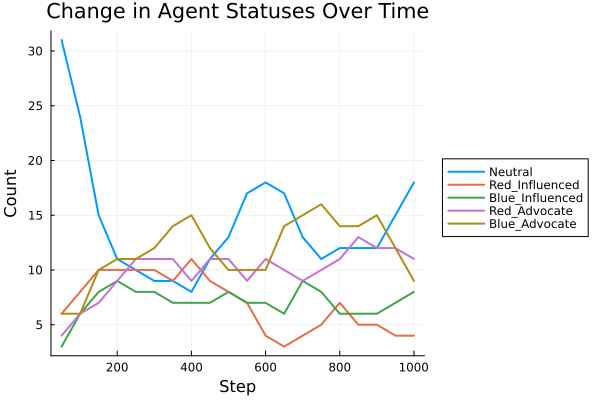

In [178]:
# Create report of agent status for 1000 steps
df = log_agent_status(model, 1000)

# Exclude the "Step" column
statuses = names(df)[2:end]  

# Create the plot for each agent's status and combine into 1 graph
Plots.plot(
    df.Step, 
    df[!, statuses[1]], 
    label=statuses[1],
    xlabel="Step", 
    ylabel="Count", 
    title="Change in Agent Statuses Over Time", 
    lw=2,
    legend=:outerright,
)

for i in 2:length(statuses)
    Plots.plot!(
        df.Step, 
        df[!, statuses[i]], 
        label=statuses[i],
        lw=2
    )
end

# Show the plot
display(Plots.current())


The plot shows that the `red store` with high customer satisfaction but a limited product selection gained a more consistent number of advocates over time, demonstrating the power of customer satisfaction in building loyalty. In contrast, the `blue store`, which had a wide range of products but low satisfaction, struggled to maintain a steady base of advocates, highlighting the importance of meeting customer expectations.

> Different scenarios can be explored by adjusting the parameters.

### **Animating Agent Interactions Over Time**

This part of the simulation adds color, shape, size to the agents base on theirs status. This helps us get a better visual of the state of the agents.

In [47]:
function agent_color(agent)
    if agent isa ShopAgent
        return agent.color
    elseif agent isa CustomerAgent

        if agent.status == :neutral
            return :black
        elseif agent.status == :blue_influenced
            return :lightblue
        elseif agent.status == :red_influenced
            return :firebrick1
        elseif agent.status == :blue_advocate
            return :darkblue
        elseif agent.status == :red_advocate
            return :darkred
        else
            return :black
        end
    end
end

function agent_marker(agent)
    if agent isa ShopAgent
        return :hexagon 
    elseif agent isa CustomerAgent
        if agent.status == :neutral
            return :circle  
        elseif agent.status == :blue_influenced
            return :cross  
        elseif agent.status == :red_influenced
            return :cross  
        elseif agent.status == :blue_advocate
            return :star5  
        elseif agent.status == :red_advocate
            return :star5  
        else
            return :square  
        end
    end
end

function agent_size(agent)
    if agent isa ShopAgent
        return 30
    else 10
    end
end


agent_size (generic function with 1 method)

#### **Plot the model at step 1000**

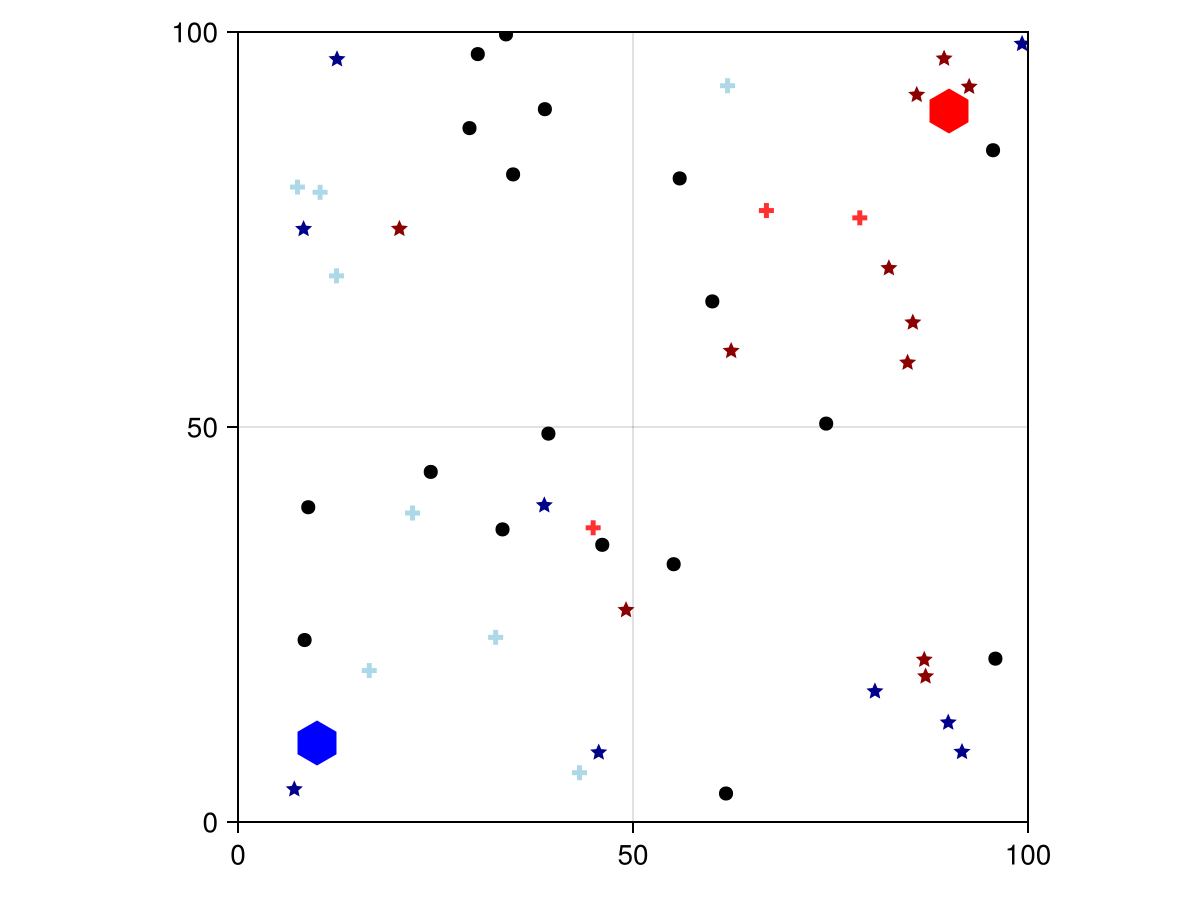

In [183]:
figure, = abmplot(model; ac=agent_color, am=agent_marker, as = agent_size)
figure

- **Shop Agents:**
    - Shape: Hexagon
    - Color: Blue for the blue shop, red for the red shop.
    - Size: Larger to stand out.

- **Customer Agents:**

    - Neutral: Black circle.
    - Blue Influenced: Light blue cross.
    - Red Influenced: Bright red cross.
    - Blue Advocate: Dark blue star.
    - Red Advocate: Dark red star.

#### **Animation**

In [171]:
model = setup_model(30, params)
abmvideo(
    "WOM.mp4", model;
    ac = agent_color, am=agent_marker, agent_size=agent_size,
    dt = 1, framerate = 30, frames = 3000,
    title = "Worth-of-Mouth Marketing"
)

> See the animation at [here](https://1drv.ms/v/s!As7E69WgMmxFh9p_uJh45Ib5XlOPPA?e=4oAzEC)

### Conclusion

This project successfully developed an agent-based model to simulate the dynamics of word-of-mouth (WOM) marketing and customer satisfaction in a competitive environment. The model captured the interplay between customer behavior and marketing strategies by incorporating agents with distinct roles (shops and customers) and attributes such as movement, loyalty, and influence power. The 2D continuous space environment allowed for realistic customer movement and shop interaction simulations.

The rules governing movement, shop visits, and WOM influence highlight how satisfaction and advocacy drive customer acquisition and loyalty. The model demonstrated the importance of customer satisfaction in fostering advocacy and the cascading effects of WOM in attracting neutral customers. Furthermore, the competitive mechanics, such as advocates impacting competitors' satisfaction probability, underscored businesses' dynamic challenges in maintaining customer loyalty.

This simulation is a foundational tool for exploring strategies to optimize customer satisfaction and effectively harness WOM marketing. Future enhancements could include Expanding agent behavior rules, Incorporating additional customer preferences, and Testing the model with more complex market scenarios.

The project could be enhanced by incorporating diverse customer types, dynamic store strategies, and more realistic, evolving environments. Adding rules like customer recall of past visits, diminishing advocate influence, and interactions between advocates could introduce greater complexity to agent behavior. Visualization tools like heat maps could highlight patterns and influences more effectively. Expanding the model with additional stores and customers, integrating social media, and using real-world data would make the simulation more realistic. Lastly, tracking metrics such as customer loyalty and market share could offer deeper insights into successful strategies.